# THÔNG TIN CÁ NHÂN

---

Họ tên: Nguyễn Nhật Trường

MSSV: 20522087

Bài tập 2 - Ngày thực hiện 16/11/2022

# YÊU CẦU 1

---

Cài đặt và sử dụng Faster-RCNN

Thử nghiệm cho 5 ảnh: pedestrian

Cho biết pedestrian-05 có bao nhiêu person ?

Xác định confidence score để xác định ít nhất 2 ảnh camourflage, 2 ảnh lính_bắn_tỉa

In [1]:
# Import nescessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

In [2]:
# Load imgages
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img,channels=3)
  return img

In [3]:
# Show an image
def display_img(img):
  fig = plt.figure(figsize=(20,15))
  plt.axis("off")
  plt.imshow(img)

In [4]:
# Function draw texts on image
def draw_bbox_text_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
 
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


In [5]:
def draw(image, max_boxes, min_score, boxes, class_names, scores, ):
  colors = list(ImageColor.colormap.values())
  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()
  detected_boxes = boxes.shape[0]
  count = 0
  for i in range(min(max_boxes, detected_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bbox_text_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [6]:
def run_detector(detector, path, max_boxes, max_score, count_human=False):
  img = load_img(path)
  converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time=time.time()
  output = detector(converted_img)
  end_time=time.time()
  print("Execute time: " + str(end_time-start_time)+"s")
  output={key:value.numpy() for key, value in output.items()}
  image_with_boxes = draw(img.numpy(), max_boxes, max_score, output['detection_boxes'], output['detection_class_entities'], output['detection_scores'])
  if count_human:
    count = 0
    for i in range(0, len(output['detection_class_entities'])):
      if output['detection_class_entities'][i] == b'Person' and output['detection_scores'][i]>max_score:
        count += 1
      elif output['detection_class_entities'][i] == b'Woman' and output['detection_scores'][i]>max_score:
        count += 1
      elif output['detection_class_entities'][i] == b'Man' and output['detection_scores'][i]>max_score:
        count += 1
      elif output['detection_class_entities'][i] == b'Boy' and output['detection_scores'][i]>max_score:
        count += 1
      elif output['detection_class_entities'][i] == b'Girl' and output['detection_scores'][i]>max_score:
        count += 1
    print("Số lượng người trong ảnh: "+str(count))
  display_img(image_with_boxes)

In [7]:
# Setting and Use Faster RCNN
faster_rcnn_url = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
print('loading model...')
detector = hub.load(faster_rcnn_url).signatures['default']
print('model loaded!')

loading model...
model loaded!


In [8]:
# Save path
path = '/content/drive/MyDrive/Colab Notebooks/cs331_advanced_cv/images/'
img_pedestrian = ['Pedestrian_01.jpg','Pedestrian_02.jpg','pedestrian-03.jpg','pedestrian-04.jpg','pedestrian-05.jpg']
img_linh_ban_tia = ['linh-ban-tia-2.jpg','linh-ban-tia-3.jpg','linh-ban-tia-4.jpg']
img_camourflage = ['camourflage_00470.jpg','camourflage_00471.jpg','camourflage_00473.jpg']

In [9]:
# Experiment with 5 pedestrian
for x in img_pedestrian:
  run_detector(detector,path+x,max_boxes = 999,max_score = 0.2)

Output hidden; open in https://colab.research.google.com to view.

Execute time: 29.800222873687744s
Số lượng người trong ảnh: 28


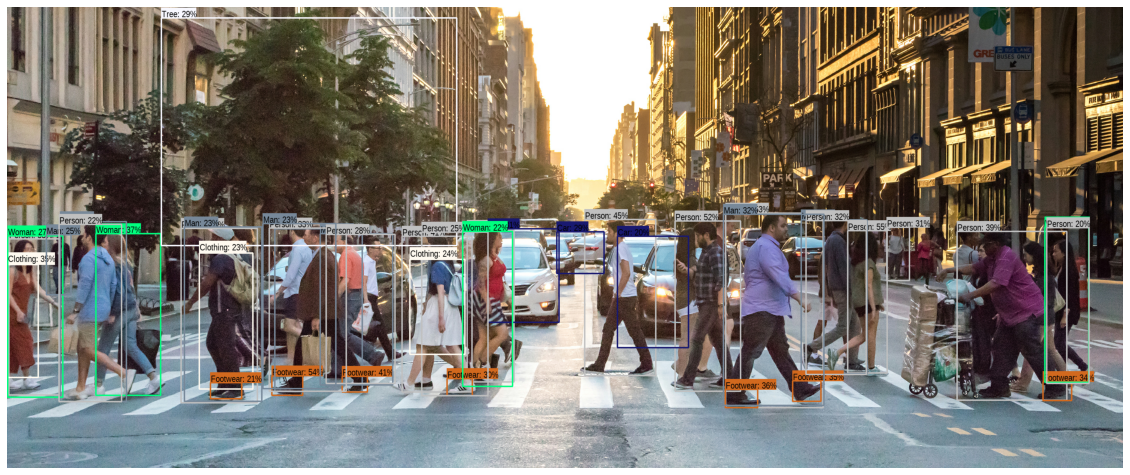

In [10]:
# The number of people in pedestrian-05
run_detector(detector,path+'pedestrian-05.jpg',max_boxes = 999,max_score = 0.2,count_human = True)

In [11]:
# Determine confidence score to determine at least 2 camourflage image, 2 lính_bắn_tỉa image
for x in img_linh_ban_tia:
  run_detector(detector,path+x,max_boxes = 9999,max_score = 0.5)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
for x in img_camourflage:
  run_detector(detector,path+x,max_boxes = 9999,max_score = 0.5)

Output hidden; open in https://colab.research.google.com to view.

# YÊU CẦU 2

---

Cài đặt và sử dụng Yolo

Thử nghiệm cho 5 ảnh: pedestrian

Cho biết pedestrian-05 có bao nhiêu person ?

Xác định confiden score để xác định ít nhất 2 ảnh camourflage, 2 ảnh lính_bắn_tỉa

In [13]:
# Import nescessary libraries for yolo
import torch
import os
import cv2

In [15]:
%cd '/content/drive/MyDrive/Colab Notebooks/cs331_advanced_cv'

/content/drive/MyDrive/Colab Notebooks/cs331_advanced_cv


In [16]:
# Git clone yolov5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15033, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15033 (delta 45), reused 63 (delta 40), pack-reused 14960
Receiving objects: 100% (15033/15033), 13.69 MiB | 6.31 MiB/s, done.
Resolving deltas: 100% (10389/10389), done.
/content/drive/MyDrive/Colab Notebooks/cs331_advanced_cv/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.0 MB/s 


In [17]:
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s')

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-11-16 Python-3.7.15 torch-1.12.1+cu113 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [18]:
def detect(path, conf=0.3):
   yolo.conf = conf
   pic =cv2.imread(path)
   start_time = time.time()
   result = yolo(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB))
   end_time = time.time()
   print("Execute time: "+ str(end_time-start_time)+"s")
   result.print()
   result.show()
   df = result.pandas().xyxy[0]

In [19]:
# Experiment with 5 pedestrian images
for x in img_pedestrian:
  detect(path+x, conf=0.3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Số lượng người trong pedestrian-05 là 21 persons 

In [20]:
# Determine confidence score to determine at least 2 camourflage image, 2 lính_bắn_tỉa image
for x in img_camourflage:
  detect(path+x, conf=0.01)

Output hidden; open in https://colab.research.google.com to view.

image 1/1: 398x600 4 birds
Speed: 7.7ms pre-process, 318.8ms inference, 1.6ms NMS per image at shape (1, 3, 448, 640)


Execute time: 0.3296225070953369s


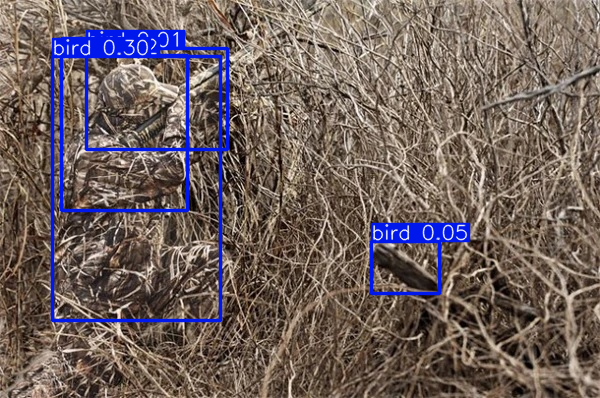

image 1/1: 398x600 1 bird
Speed: 5.5ms pre-process, 450.4ms inference, 1.9ms NMS per image at shape (1, 3, 448, 640)


Execute time: 0.45941853523254395s


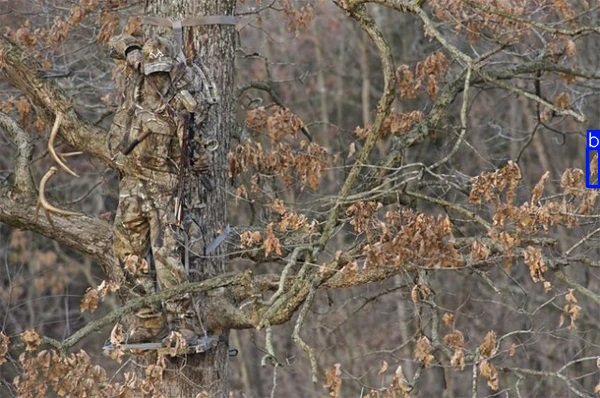

image 1/1: 400x600 11 giraffes
Speed: 5.2ms pre-process, 399.5ms inference, 1.5ms NMS per image at shape (1, 3, 448, 640)


Execute time: 0.41277146339416504s


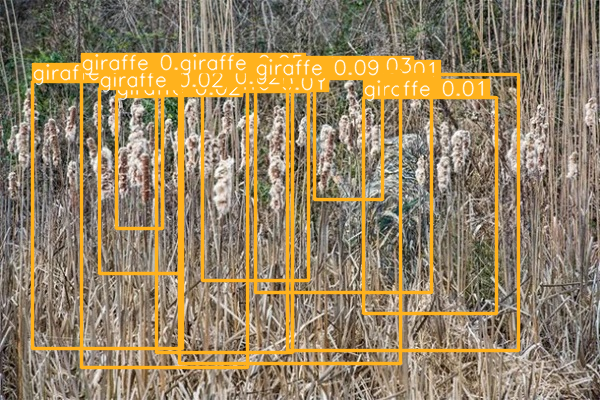

In [21]:
for x in img_linh_ban_tia:
  detect(path+x, conf=0.01)

# YÊU CẦU 3

---

So sánh thời gian detect của Faster-RCNN và Yolo trên cùng 1 ảnh pedestrian-05.jpg

Execute time: 31.215896368026733s
Số lượng người trong ảnh: 28


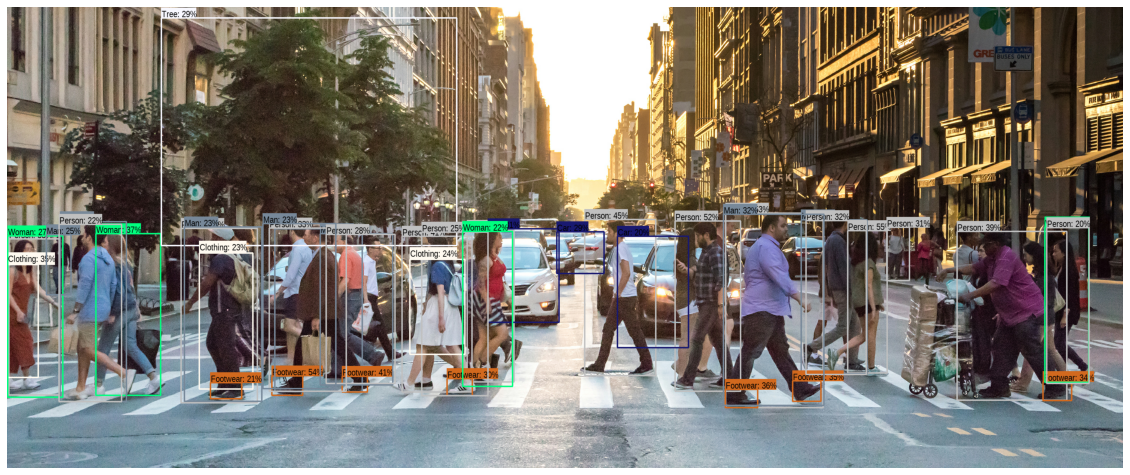

In [22]:
# Time comparison of Faster R-CNN and YOLO in the same pedestrian-05 image

# With Faster R-CNN
run_detector(detector,path+'pedestrian-05.jpg',max_boxes = 9999,max_score = 0.2,count_human = True)

In [23]:
# With Yolo-v5
detect(path+'pedestrian-05.jpg', conf=0.3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
'''
Execute time of Faster RCNN: 31.215896368026733s
Execute time of Yolo-v5: 0.23349523544311523s

While faster R-CNN's time consumption is 31.215896368026733s , yolo-v5's time consumption is 0.23349523544311523s.
'''